# **Background and Overview**  
Falls are a major risk, especially for the elderly, high-risk workers, and individuals with mobility issues. According to WHO, falls are a leading cause of severe injuries and fatalities, often resulting in reduced confidence and quality of life. AI-driven fall detection uses video and image analysis to identify falls automatically, enabling faster and more accurate intervention. However, distinguishing falls from normal activities and ensuring models perform well in real-world conditions remain key challenges.  


**Our Approach**  
We developed a fall detection model using **InceptionV3**, achieving **0.961 accuracy**. This result highlights the effectiveness of deep learning in fall detection, with ongoing efforts to improve generalization and reduce false positives.


# **Methodology**  
To improve fall detection accuracy, we explored multiple modeling approaches, refining performance at each step:  

1. **Pose Features (Mediapipe) – 0.88 Accuracy**  
We began by using **Mediapipe** to extract skeletal features and body posture from video frames. While this method efficiently tracked joint movements, it often misclassified normal activities (e.g., sitting or lying down) as falls, limiting accuracy to **0.88**.  

2. **ResNet50 + Augmentation – 0.916 Accuracy**  
Next, we implemented **ResNet50**, a deep CNN, with **image augmentation** techniques like rotation, flipping, and scaling. This enhanced the model’s ability to generalize across various conditions, increasing accuracy to **0.916**.  

3. **EfficientNetB0 – 0.93 Accuracy**  
We then applied **EfficientNetB0**, known for balancing performance and efficiency. Its superior feature extraction and lightweight architecture further improved accuracy to **0.93**.  

Finally, after iterating on these models, we selected **InceptionV3** as our final architecture. This model achieved **0.961 accuracy**, leveraging its advanced deep learning capabilities for superior feature extraction and classification. InceptionV3 outperformed the previous models by better capturing complex patterns and nuances in the data, leading to more reliable fall detection results.


## **Used Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# Paths to the train and test directories
train_dir = '/kaggle/input/data-slayer-2-0-machine-learning-competition/train'
test_dir = '/kaggle/input/data-slayer-2-0-machine-learning-competition/test'

In [3]:
# Constants
IMG_SIZE = 224  # Resize all images to 224x224
BATCH_SIZE = 32
EPOCHS = 25  # Increased epochs for better training
LEARNING_RATE = 0.0001  # Reduced learning rate for fine-tuning

## **Loading Training and Testing Data**
This code preprocesses images for a fall detection model. It resizes and normalizes images to a fixed size and pixel range. 

- The `preprocess_image` function loads, resizes, and normalizes images.  
- For training, it loops through the directories, labeling images as "fall" (1) or "non-fall" (0) and stores them in `train_data` and `train_labels`.  
- For testing, it processes test images and stores them in `test_images` with their filenames in `test_ids`.

The result is a preprocessed dataset ready for model training and testing.


In [4]:
# Function to preprocess images
def preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))  # Resize
        img = img_to_array(img) / 255.0  # Normalize to [0,1]
        return img
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

# Load training data
train_data = []
train_labels = []

for subject in os.listdir(train_dir):
    subject_path = os.path.join(train_dir, subject)
    for category in os.listdir(subject_path):
        category_path = os.path.join(subject_path, category)
        label = 1 if category == 'fall' else 0  # Label fall = 1, non-fall = 0
        
        for root, _, files in os.walk(category_path):
            for file in files:
                img_path = os.path.join(root, file)
                img = preprocess_image(img_path)
                if img is not None:
                    train_data.append(img)
                    train_labels.append(label)

# Load and preprocess test images
test_images = []
test_ids = []

for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    img = preprocess_image(img_path)
    if img is not None:
        test_images.append(img)
        test_ids.append(img_file)

In [5]:
# Convert to NumPy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

## **Exploratory Data Analysis**
The dataset given is a folder of images containing samples of people falling and not falling with a total of 6446 ‘.jpg’ images. There are 4 persons as subjects each with **fall samples** and **non-fall samples**. The falling samples have 6 subcategories: **backward falls, forward falls, left falls, right falls, sitting falls, and standing falls**. There are also 6 subcategories for non-fall: **jumping, laying, picking, squat, stretching, and walking**. The image in the dataset itself has a resolution of 1280 x 720. These make up the train dataset, and there are **4294 images in total**.

In addition to the train dataset, there is a **test image folder containing 2152 images**, where the model is supposed to make a prediction on. This will be used for the model to make the competition submission.

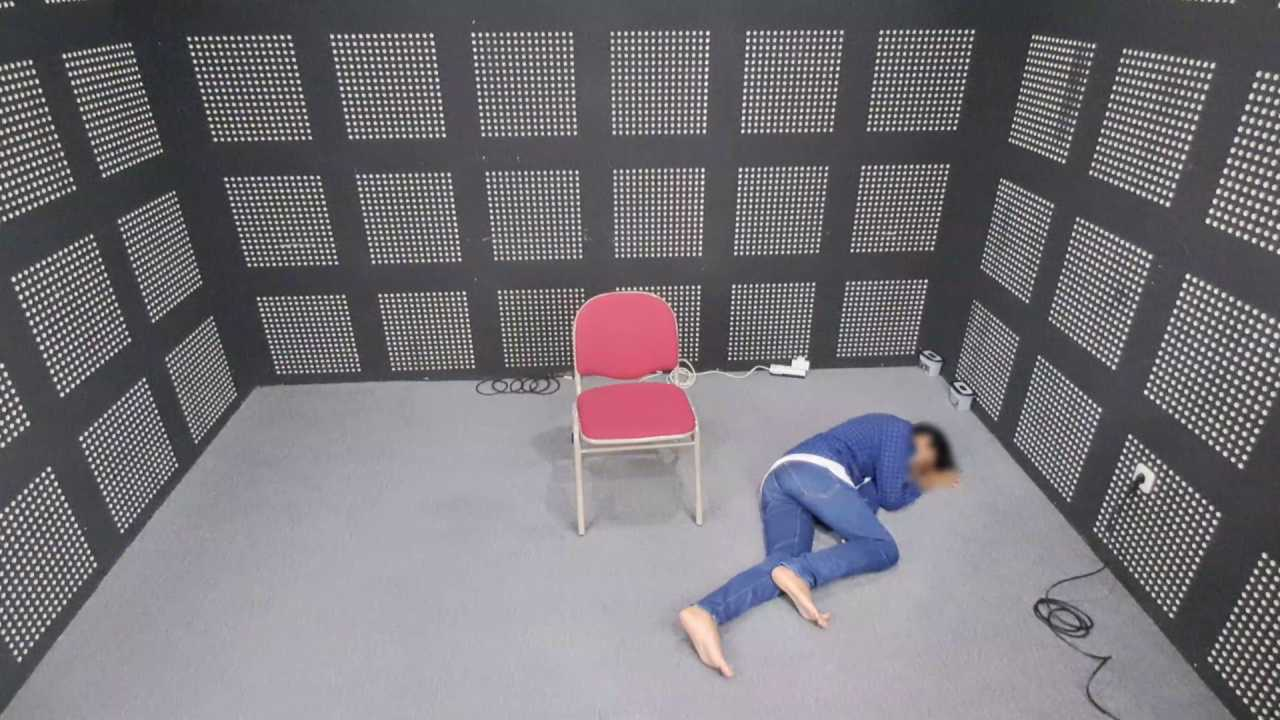

1_sitting_falls

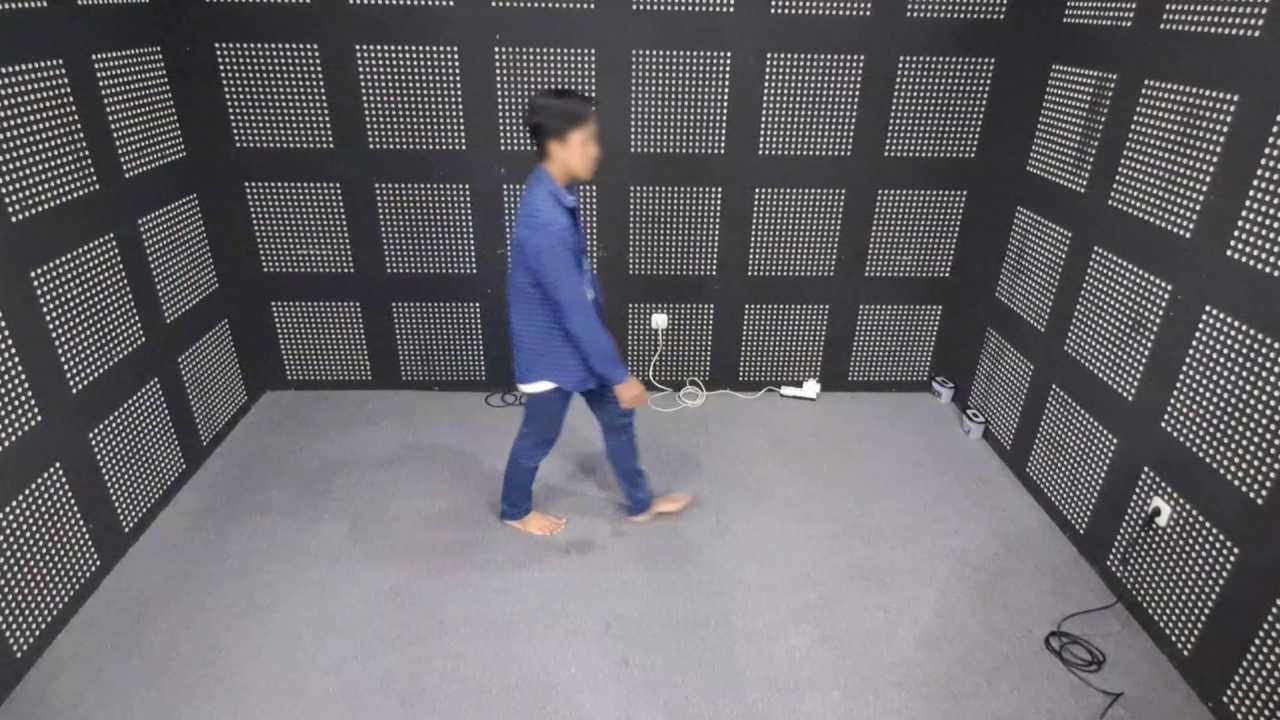

1_walking

In [6]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 3435, Validation samples: 859


## **Tested Models**

### **1. Pose Features & Sequential Neural Networks**
This code uses the MediaPipe library to extract pose features from images, which are then prepared for use in a machine learning model. First, the MediaPipe Pose module is initialized with a minimum detection confidence of 50%, enabling pose detection for static images. The extract_pose_features function processes each input image to detect human pose landmarks, returning a flattened list of keypoint coordinates (x, y, z) and visibility for each of the 33 keypoints. If no pose is detected, the function returns a zero vector of appropriate length. The code then loops through the training images, rescales them to the [0, 255] range, and extracts pose features for each image, storing them in a list. This list is then converted into a NumPy array to facilitate further analysis. Using this approach, the model achieves an accuracy of 0.88, based on the accuracy metric.


### **2. Resnet-50 + Image Augmentation**
We also explored the use of another model, ResNet50 [4]. ResNet50 was chosen because it is a well-established and powerful model for solving computer vision problems. ResNet50 works by adding the input features from earlier layers to the output features of layers deeper in the network. This is called a skip connection. Skip connections minimize or eliminate the negative impact of certain layers that might degrade model performance. The effect of skip connections is similar to regularization parameters in other models (like L1 or L2 regularization). This method allows for the addition of many layers without risking vanishing gradients, where weights shrink due to the large number of layers. Very small weights prevent the model from generalizing predictions on input images [1] [3] [5]. Figure 1 illustrates skip connections and the ResNet50 architecture [2]: Another key feature of this implementation is the use of image data augmentation. Augmentation is applied to help the model generalize to input images with slight variations. This process generates new samples from the given dataset by introducing minor changes, such as mirroring or rotating images. Using this approach, the model achieves an accuracy of 0.91.

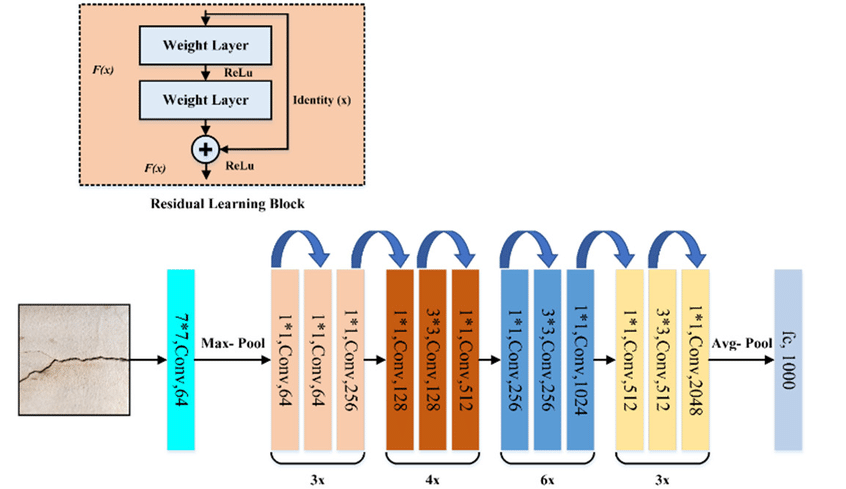 

*Figure 1: Illustration of Skip Connections and the ResNet50 Architecture*


### **3. EfficientNetB0**
EfficientNetB0 is a deep convolutional neural network architecture designed for image classification. It leverages a technique called compound scaling, where it uniformly scales the network's depth, width, and resolution to achieve higher accuracy with fewer parameters and computations compared to traditional architectures. EfficientNetB0 starts with a baseline model, and through a search process, it finds the optimal balance between these three dimensions. It uses depthwise separable convolutions, which reduce computational complexity while maintaining performance. This makes EfficientNetB0 both efficient and accurate, achieving strong performance on image classification tasks with a relatively small computational cost, and resulting in an accuracy of 0.93.

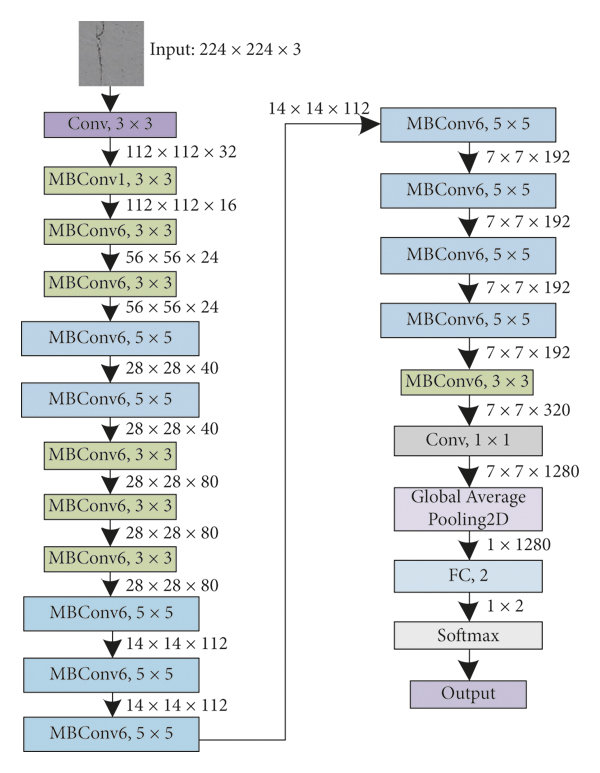

*Figure 2: Illustration of EfficientNetB0 Architecture*


## Final Proposed-Model

Essentially, Inception neural network in general works by expanding the network, or widening, as opposed to extending the layer deeper like ResNet does.
It processes the output of a layer into multiple transformations using different
convolution or multiple processes (such as pooling) before entering the next
layer. The result of each filter or layer will be concatenated before entering
the next layer [7]. This addresses the issue of choosing which filter is the most
optimized for the image [6].

1. Factorized Convolutions: Instead of using larger convolutions, InceptionV3
employs smaller convolutions, such as factorizing a 5×5 convolution into
two successive 3×3 convolutions. This approach reduces computational
costs and mitigates overfitting.
2. Auxiliary Classifiers: To address the vanishing gradient problem in deep
networks, InceptionV3 includes auxiliary classifiers at intermediate layers. These classifiers provide additional gradient signals during training,
enhancing convergence and acting as regularizers.
3. Label Smoothing: InceptionV3 introduces label smoothing during training, which distributes some probability mass from the true label to other
labels. This technique helps prevent overfitting and improves model calibration.


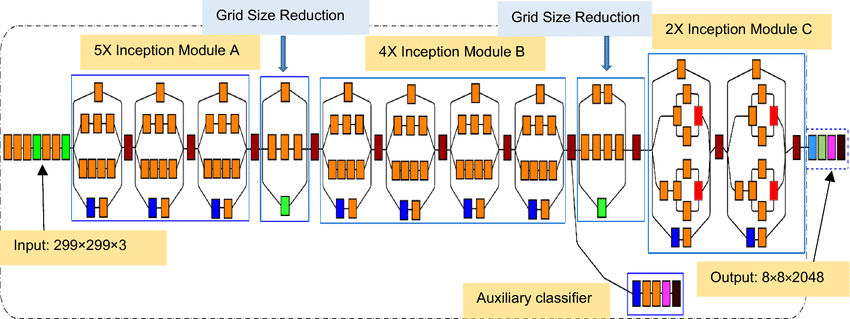
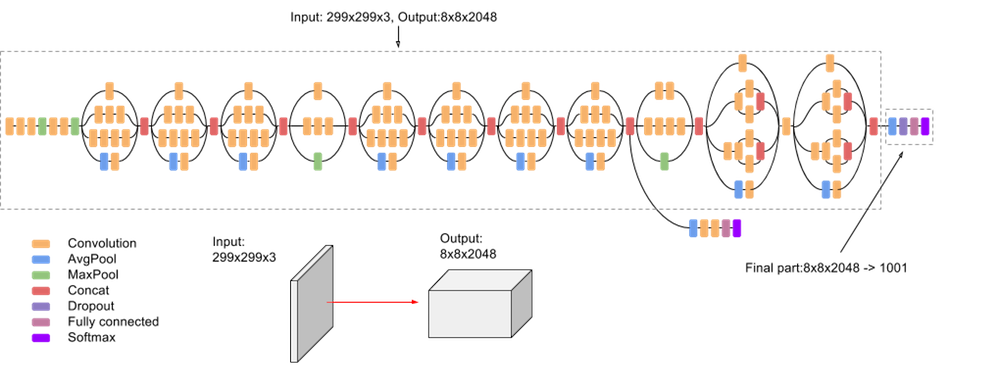
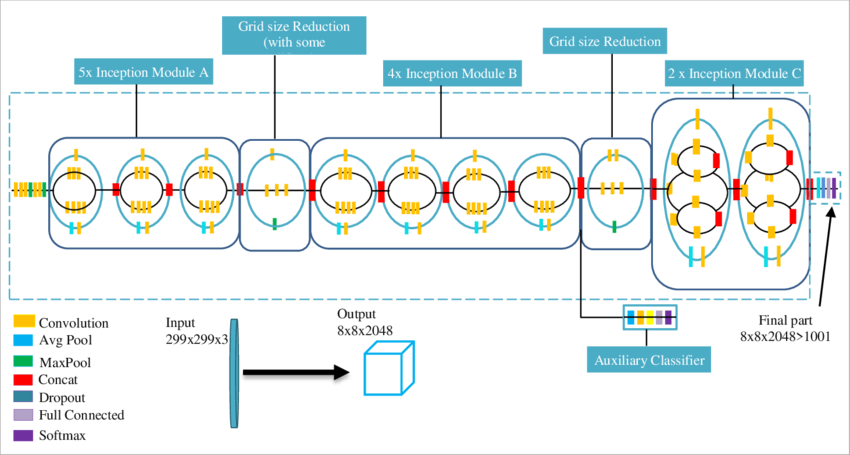

In [7]:
# Load pre-trained InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Fine-tuning: Unfreeze some layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Regularization
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 22,030,753 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [8]:
# Early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/25


I0000 00:00:1735146130.094532     177 service.cc:145] XLA service 0x78a93c129d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735146130.094596     177 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1735146130.094600     177 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1735146172.207030     177 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 144s 671ms/step - accuracy: 0.8817 - loss: 0.2458 - val_accuracy: 0.8556 - val_loss: 0.6171
Epoch 2/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 252ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9872 - val_loss: 0.0357
Epoch 3/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 278ms/step - accuracy: 0.9957 - loss: 0.0177 - val_accuracy: 0.9930 - val_loss: 0.0150
Epoch 4/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 266ms/step - accuracy: 0.9950 - loss: 0.0165 - val_accuracy: 0.9965 - val_loss: 0.0076
Epoch 5/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 28s 260ms/step - accuracy: 0.9977 - loss: 0.0065 - val_accuracy: 0.9953 - val_loss: 0.0092
Epoch 6/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 268ms/step - accuracy: 0.9997 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 2.5497e-04
Epoch 7/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 266ms/step - accuracy: 1.0000 - loss: 3.9664e-04 - val_accuracy: 1.0000 - val_loss: 6.1855e-04
Epoch 8/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 264ms/step - accuracy: 0.9980 - loss:

In [9]:
# Generate predictions as probabilities on validation set
val_probs = model.predict(X_val)

# Find the best threshold using F1 score
thresholds = np.arange(0.1, 1.0, 0.01)
f1_scores = [f1_score(y_val, (val_probs > t).astype(int)) for t in thresholds]
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1 = f1_scores[best_threshold_index]

print(f"Best Threshold: {best_threshold}")
print(f"Best F1-Score: {best_f1}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step
Best Threshold: 0.1
Best F1-Score: 1.0


In [10]:
# Predict labels for test data using the optimized threshold
predictions = model.predict(test_images)
predicted_labels = (predictions > best_threshold).astype(int).reshape(-1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step


In [11]:
# Save predictions to sample_submission.csv
submission = pd.DataFrame({'id': test_ids, 'label': predicted_labels})
submission.to_csv('submission.csv', index=False)
print("Submission file saved!")


Submission file saved!


## **Saving Model**
We saved the model in h5 format


In [12]:
# Save the model to an H5 file
model.save('inceptionv3_model.h5')
print("Model saved to inceptionv3_model.h5")

Model saved to inceptionv3_model.h5


## Evaluation

### **Confusion Matrix**
If the predictions alone are observed, it can be observed that the model predicts all the fall and non-fall categories accurately with no classification. Again, similar to the loss and accuracy graph, this could either mean the model performs well or overfits. The model performs well in the Kaggle competition. Generally speaking, this will indicate overfitting. 

### **Learning and Loss Curve**
The performance of the model can be observed. The graph shows that the model achieves an accuracy of 100%, with a loss of nearly 0 in training and validation, as the model progresses through the epoch. There are 2 implications from this observation. Firstly, the model simply explains the model exceptionally well, or the model overfits. Given that our Kaggle submission on 30% of the test data results in 96.1% accuracy, this could mean that the model could generalize well. However, in general, this might indicate a case of overfitting.

### **Prediction Samples**
In addition to the matrix, the images are printed with their respective prediction from the model. This is done for a better visualization and analysis on the model’s performance because the matrix itself does not explicitly tell us what kind of images they predict right, and what kind of images they predict wrong.

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


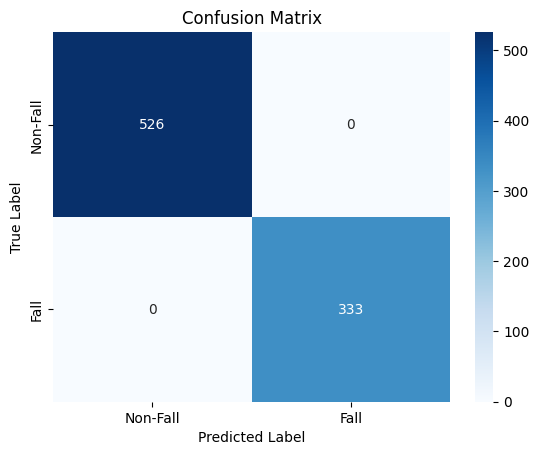

In [13]:
# Get validation predictions
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fall", "Fall"], yticklabels=["Non-Fall", "Fall"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


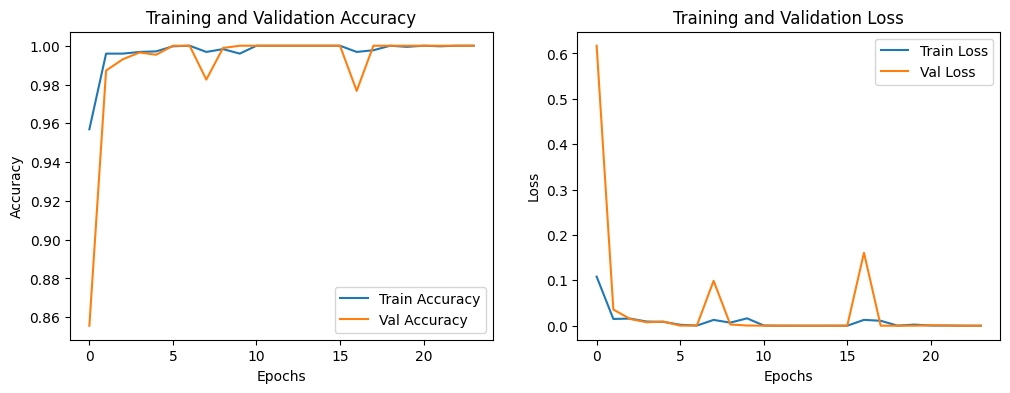

In [14]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


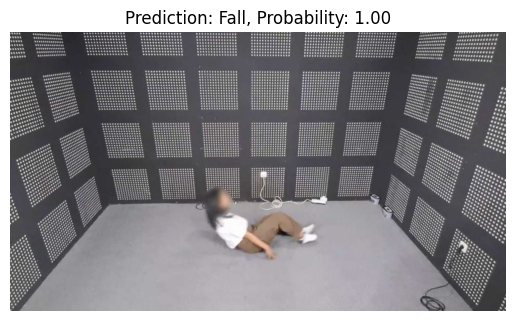

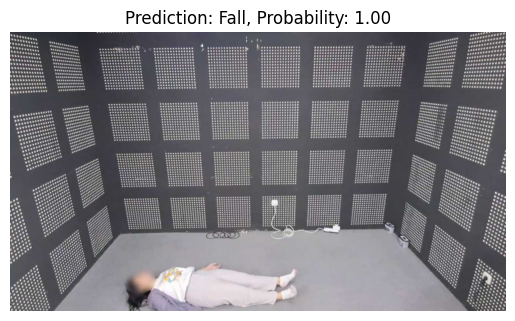

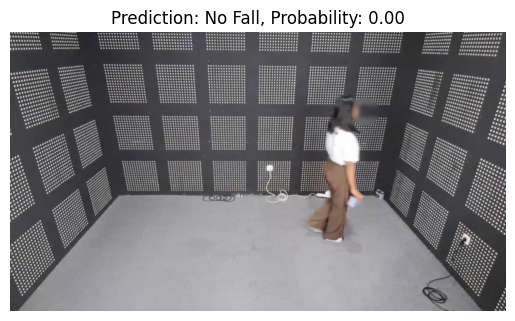

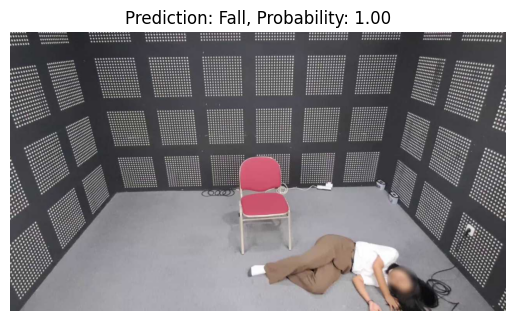

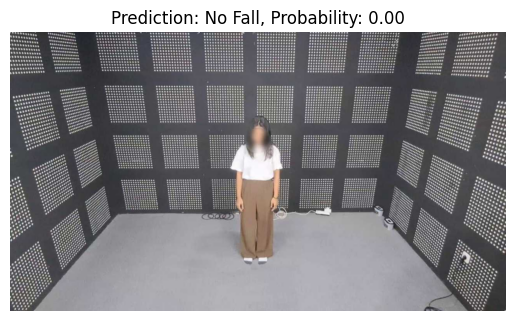

In [15]:
for img_id, pred in zip(test_ids[:5], predictions[:5]):  # Show the first 5 images
    img_path = os.path.join(test_dir, img_id)
    img = Image.open(img_path)

    plt.imshow(img)
    plt.title(f"Prediction: {'Fall' if pred >  best_threshold else 'No Fall'}, Probability: {pred[0]:.2f}")
    plt.axis('off')
    plt.show()

# Conclusion
1. We were able to reach an accuracy of 0.961 due to InceptionV3's strong pre-trained feature extraction capabilities, its efficient architecture utilizing Inception modules to capture multi-scale spatial features, its ability to effectively learn hierarchical patterns critical for distinguishing fall-related and non-fall postures, and its adaptability to small to medium-sized datasets like ours.
   
2. Inability to Differentiate Between Similar Poses:
   > * our model have troubles differentiating similar poses like Laying down(non-fall)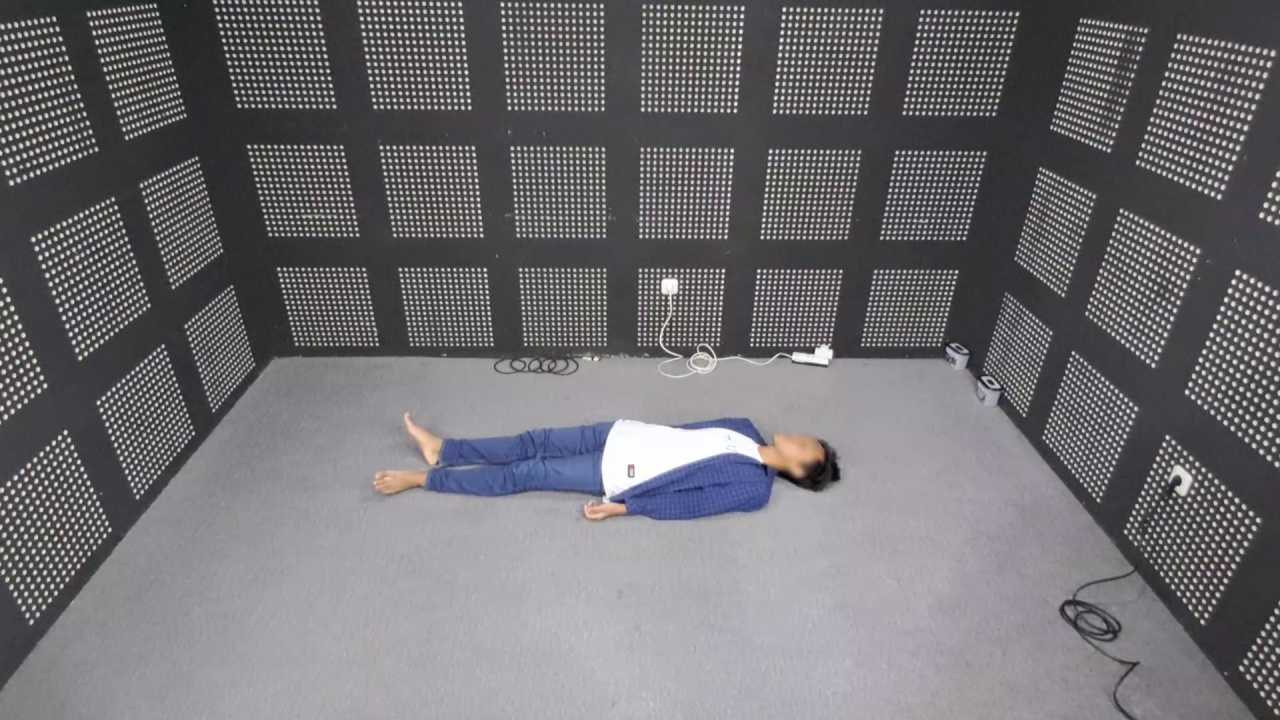 and Falling backwards(Fall) 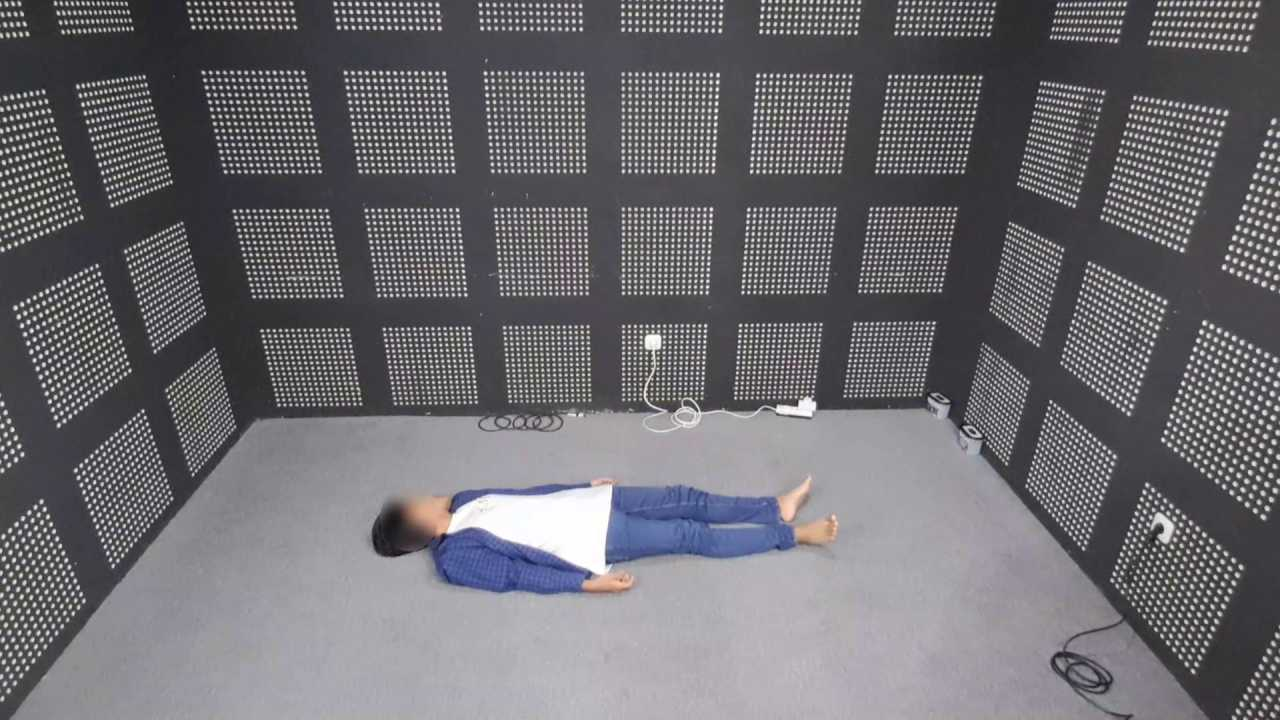
   > * This happens due to the lack of temporal context on the test dataset making it difficult for the model to  differentiate
   
3. Further Improvements:
   > * Adding a pose detection could prove to do well, as we have tried, but it did not integrate effectively with InceptionV3 due to mismatched feature representations and the difficulty in aligning skeletal keypoint data with the convolutional features extracted by the model. To improve this, we could explore combining pose detection with InceptionV3 through a multi-stream architecture, where one stream processes raw images and the other processes skeletal data, merging their outputs for final classification.
   > * To address the challenges our model faced, we propose an improved approach: instead of predicting just two categories fall or non-fall we would have the model predict subcategories, with 12 labels in total (6 for fall and 6 for non-fall). Once these subcategories are classified, we can map them back into binary labels for fall and non-fall. This approach allows the model to learn finer-grained distinctions, which could enhance its ability to differentiate between similar actions.
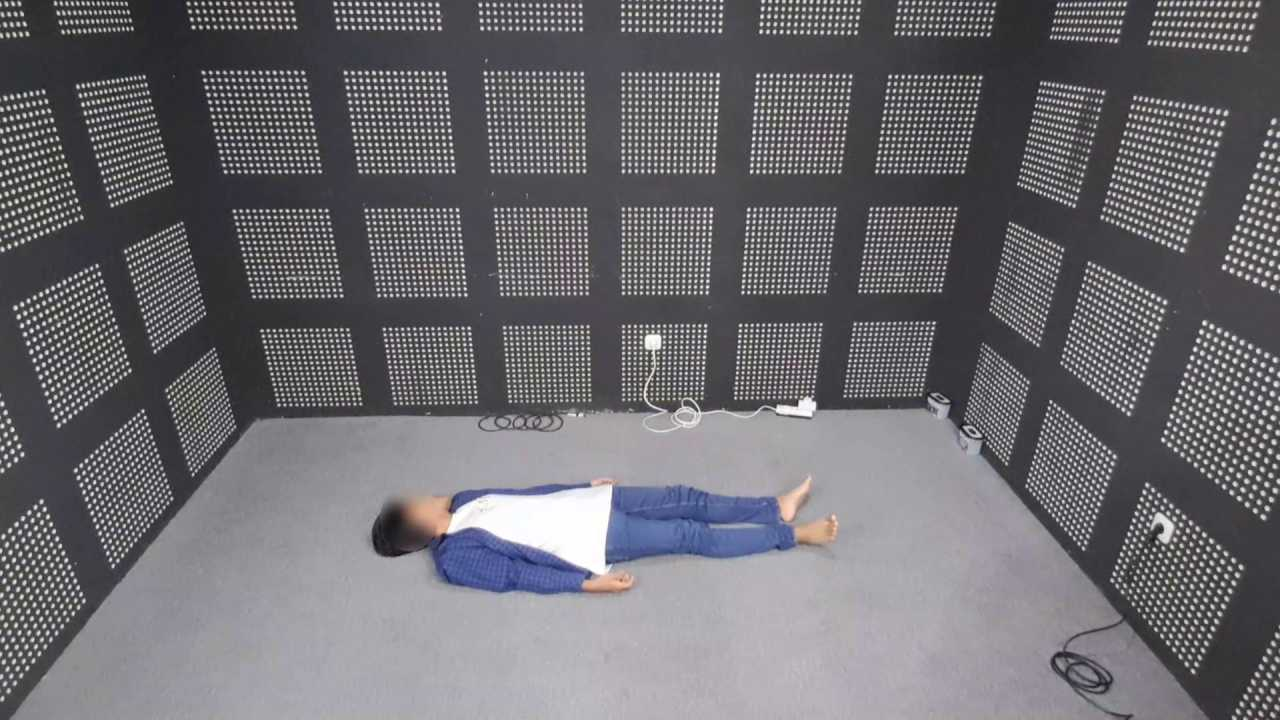

# References
- [1] Residual networks (resnet) - deep learning - geeksforgeeks, 1 2023.
- [2] Understanding resnet-50 in depth: Architecture, skip connections, and advantages over other networks - wisdom ml, 3 2023.
- [3] Ryan Ahmed. (532) what is resnet? (with 3d visualizations) - youtube, 10 2022.
- [4] Kaiming He, X. Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recognition. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), pages 770–778, 2015.
- [5] Rupert Meneer. (532) resnet (actually) explained in under 10 minutes - youtube, 3 2022.
- [6] Block diagram of inception-v3 improved deep architecture — download scientific diagram.
- [7] Asrar G. Alharthi and Salha M. Alzahrani. Do it the transformer way: A comprehensive review of brain and vision transformers for autism spectrum disorder diagnosis and classification. Computers in Biology and Medicine, 167, 12 2023.
- [8] Nicolai Nielsen. (536) inception explained: Understanding the architecture and module of inception networks - youtube, 5 2021.
